In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
from os.path import join
import torch
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os.path import join as oj
import torch.utils.data as utils
from torchvision import datasets, transforms
import numpy as np
import os
import sys
pd.set_option('precision', 3)

In [35]:
save_path = "../results_for_export"
trained_model_folder = '../mnist_adversarial/'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'block' not in fname]) 
# other models were trained badly

results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects() 
results['final_acc'] = [max(x) for x in results['accs_test']] 

In [36]:
results = results[results.final_acc > 85]
results = results[results.dataset == "Fashion"]

In [37]:
results['final_acc'] = [x[-1] for x in results['accs_test']] 
results['final_acc_train'] = [max(x) for x in results['accs_train']]


results['final_cd'] = [x[-1] for x in results['cd']]
results['final_test_loss'] = [x[-1] for x in results['losses_test']]


results['final_train_loss'] = [min(x) for x in results['losses_train']]
results['acc_color'] = [0 for x in results['accs_train']]
if not 'method' in list(results.columns):
    results['method'] = ['CD' for x in results['accs_train']]
if not 'method' in list(results.columns):
    results['method'] = ['CD' for x in results['accs_train']]
results["fool"] =[0 for x in results['accs_test']]

In [38]:
results = results.dropna()

results.reset_index(drop=True, inplace=True)
results_save = results[['regularizer_rate','final_acc','final_acc_train','final_test_loss','fool' ]].sort_values(by = ['regularizer_rate'])

In [60]:
results_save = results[['regularizer_rate','final_acc','final_acc_train','final_test_loss','fool' ]].sort_values(by = ['regularizer_rate'])

In [61]:
concise_results = results_save.groupby(by = ['regularizer_rate']).mean()

In [62]:
results_save

,regularizer_rate,final_acc,final_acc_train,final_test_loss,fool
1,0.00,87.75,90.234,0.339,0.071
3,0.01,84.53,84.766,0.428,0.083
5,0.01,88.75,92.969,0.318,0.069
6,0.01,88.25,92.578,0.325,0.064
4,0.10,88.68,90.625,0.316,0.054
7,0.10,88.61,94.531,0.319,0.063
0,1.00,87.47,91.016,0.339,0.049
2,1.00,86.35,89.062,0.367,0.047


In [63]:
concise_results

,final_acc,final_acc_train,final_test_loss,fool
regularizer_rate,,,,
0.00,87.750,90.234,0.339,0.071
0.01,87.177,90.104,0.357,0.072
0.10,88.645,92.578,0.318,0.058
1.00,86.910,90.039,0.353,0.048


In [43]:
print(concise_results[['fool']].to_latex())

\begin{tabular}{lr}
\toprule
{} &  fool \\
regularizer\_rate &       \\
\midrule
0.00             &     0 \\
0.01             &     0 \\
0.10             &     0 \\
1.00             &     0 \\
\bottomrule
\end{tabular}



In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    def logits(self, x):
    
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x
test_net = Net()
test_net = test_net.to(0)

In [45]:
import foolbox
import torch
import torchvision.models as models
import numpy as np
from tqdm import tqdm_notebook
from foolbox.criteria import Misclassification, TargetClass
from foolbox.distances import Linfinity

In [46]:

val_dataset = datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0,), (1,))
                       ]))
test_loader_adversarial = utils.DataLoader(val_dataset,
        batch_size=1, shuffle=True) # create your dataloader

test_net = Net()
test_net = test_net.to(0)
test_net = test_net.eval()

In [47]:
val_dataset = datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0,), (1,))
                       ]))
test_loader_adversarial = utils.DataLoader(val_dataset,
        batch_size=1, shuffle=False) # create your dataloader


In [48]:
import torchvision.datasets as datasets

In [49]:
len(results)

8

In [64]:
#TODO num distances
mean = 0.1307
std = 0.3081
num_examples =10

list_of_distances = []
for i in tqdm_notebook(range(len(results))):
    used_examples = num_examples
    test_net.load_state_dict(results.model_weights[i])
    test_net.eval()
    fmodel = foolbox.models.PyTorchModel(
    test_net, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
    tot_distance = 0

        
    attack = foolbox.attacks.LocalSearchAttack(fmodel, criterion=Misclassification(), distance = foolbox.distances.Linfinity)

    for j  in tqdm_notebook(range(num_examples)):
        adversarial = attack(val_dataset[j][0].numpy(), val_dataset[j][1],unpack = False,)
       
        tot_distance+=adversarial.distance.value


    list_of_distances.append(tot_distance/used_examples)

           
# results['fool'] =[x for x in list_of_distances]

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/lauri/.local/lib/python3.6/site-packages/foolbox/a

/home/lauri/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [65]:
results['fool'] =[x for x in list_of_distances]

In [66]:
list_of_distances

[inf, inf, inf, inf, inf, inf, inf, inf]

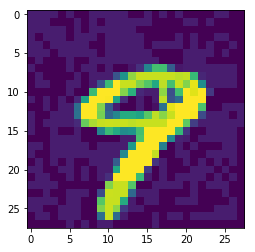

In [42]:
plt.imshow(adversarial.image[0])